## Import the required libraries

In [2]:
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator, H2OAutoEncoderEstimator

import pandas as pd
from ggplot import *
import getpass
import seaborn as sns
%matplotlib inline

from numpy.random import randn, choice, seed
from itertools import product
from numpy import sign, ceil, hstack, concatenate
seed(1)

## Connecting to the H2O cluster (with you own credential)

In [5]:
h2o.init(port = 54324,
         username = "aghorbani", 
         password = getpass.getpass())

········


H2O cluster uptime:,17 hours 50 minutes 29 seconds 895 milliseconds
H2O cluster version:,3.9.1.3458
H2O cluster name:,AwesomeCloud
H2O cluster total nodes:,1
H2O cluster total free memory:,6.84 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,2
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54324
H2O Connection proxy:,None


## Create synthetic data

In [6]:

# Generate problem data
m, k = 100, 3
n1 = 4 # cols of numerical data
n2 = 3 # cols of ordinal data
n3 = 3 # cols of boolean data
n = n1+n2+n3
data = randn(m,k).dot(randn(k,n))
data_real = data[:,:n1] # numerical data
data_ord = data[:,n1:n1+n2] 
data_ord = data_ord - data_ord.min()
data_ord = (data_ord/data_ord.max()*6 + 1).round()# ordinal data, e.g., Likert scale
data_bool = sign(data[:,n1+n2:])

# Initialize model
A = concatenate((data_real, data_ord, data_bool), axis=1)

## Load into H2O

In [7]:
A_h2o_frame = h2o.H2OFrame(A)


Parse Progress: [##################################################] 100%


## Train autoencoder

In [8]:
ae_model = H2OAutoEncoderEstimator(
    activation            = "Tanh", 
    hidden                = [5, 3, 5], 
    hidden_dropout_ratios = [0.2,0.2,0.2],
    input_dropout_ratio   = 0.2,
    epochs                = 10,
    model_id              = "yooHoo_my_awesome_autoencoder")

ae_model.train(x                = A_h2o_frame.columns,
               training_frame   = A_h2o_frame)


deeplearning Model Build Progress: [##################################################] 100%


## Score anomality of the data

In [9]:
anom_df = ae_model.anomaly(A_h2o_frame)

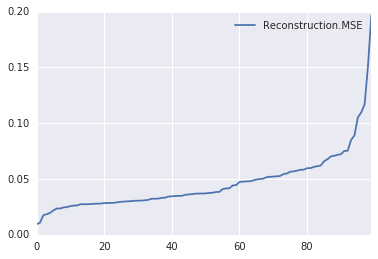

In [10]:
anom_df.as_data_frame().sort("Reconstruction.MSE").plot(use_index=False)

In [11]:
df = anom_df.cbind(A_h2o_frame)

In [12]:
df[df["Reconstruction.MSE"] > 0.1]

Reconstruction.MSE,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0.105213,-1.96369,0.447962,-1.39303,1.35437,2,3,4,-1,1,1
0.15139,3.74789,-2.94335,1.78905,-3.80711,6,6,4,1,-1,1
0.11685,-4.4386,2.01582,-0.988824,2.60152,2,2,4,1,1,1
0.197003,-4.50504,2.7381,-1.80608,3.70096,1,2,4,-1,1,1
0.109588,-3.64308,4.40846,5.11309,0.875529,7,3,4,1,-1,1


## Retrain the model with the same data

In [13]:
ae_model = H2OAutoEncoderEstimator(
    activation            = "Tanh", 
    hidden                = [5, 3, 5], 
    hidden_dropout_ratios = [0.2,0.2,0.2],
    input_dropout_ratio   = 0.2,
    epochs                = 1000,
    checkpoint            = "yooHoo_my_awesome_autoencoder",
    model_id              = "yooHoo_my_awesome_autoencoder")

ae_model.train(x                = A_h2o_frame.columns,
               training_frame   = A_h2o_frame)


deeplearning Model Build Progress: [##################################################] 100%


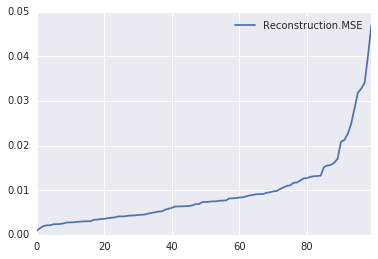

In [14]:
anom_df = ae_model.anomaly(A_h2o_frame)
anom_df.as_data_frame().sort("Reconstruction.MSE").plot(use_index=False)

In [15]:
df = anom_df.cbind(A_h2o_frame)
df[df["Reconstruction.MSE"] > 0.1]

## Deep Features

In [16]:
ae_model.deepfeatures(A_h2o_frame,1)


deepfeatures Progress: [##################################################] 100%


DF.L2.C1,DF.L2.C2,DF.L2.C3
-0.93484,0.234327,0.894217
-0.726878,-0.516721,-0.780295
-0.925123,0.332231,0.902505
-0.742615,-0.382698,-0.774972
0.962838,0.235068,-0.4193
-0.660529,-0.532455,-0.549475
-0.725447,-0.211581,-0.439874
-0.701872,0.41007,-0.387577
-0.916047,-0.00069618,0.851144
0.902972,-0.230462,-0.610656
